# German Credit Dataset

##### En este Notebook vamos a estudiar el efecto del fairness seleccionando el sexo como variable sensible

In [1]:
# Con esta celda, podemos hacer cambios en cualquier script/libreria y verlo reflejado en las funciones del notebook.
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!pip install tensorflow
!pip install matplotlib


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install pandas
!pip install numpy


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
## CARGAMOS LIBRERIAS
# Obs: La primera vez puede tardar en cargar porque AIF360 pre-compila algunas cosas de tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

# Cargamos librerías de sklearn
# vanilla LR
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Cargamos xgboost
from xgboost import XGBClassifier

# Cargamos algoritmos de fairness
# Pre-procesado
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.preprocessing import DisparateImpactRemover
# In-procesado
from aif360.algorithms.inprocessing import PrejudiceRemover
from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing
# Post-procesado
from aif360.algorithms.postprocessing import RejectOptionClassification # when scores are given

from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing # when scores (R) are given
from aif360.algorithms.postprocessing import EqOddsPostprocessing # when labels (Y^hat) are given
from aif360.datasets import GermanDataset

# TF para adversarial debiasing
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

from IPython.display import Markdown, display

# Librería local con funciones de ayuda extra
import utils

seed = 12345 # fijamos la semilla de números aleatorios para reproducir exactamante el notebook

c:\Users\sbenitez\AppData\Local\Programs\Python\Python312\Lib\site-packages\inFairness\utils\ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(


c:\Users\sbenitez\AppData\Local\Programs\Python\Python312\Lib\site-packages\inFairness\utils\ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  monte_carlo_vect_ndcg = vmap(vect_normalized_discounted_cumulative_gain, in_dims=(0,))


In [5]:
label_map = {1.0: 'Good Credit', 2.0: 'Bad Credit'}  
protected_attribute_maps = [{1.0: 'Male', 0.0: 'Female'}]

# Carga con metadata y sin modificar el procesamiento por defecto
dataset_german = GermanDataset(
    protected_attribute_names=['sex'],
    privileged_classes=[['male']],
    features_to_drop=['personal_status', 'foreign_worker'],
    metadata={'label_maps': [label_map],
              'protected_attribute_maps': protected_attribute_maps}
)

# El xgboost requiere que los labels empiecen en 0, y en este conjunto empiezan en 1
dataset_german.labels[dataset_german.labels.ravel() == 2] =  dataset_german.labels[dataset_german.labels.ravel() == 2] - 2
dataset_german.unfavorable_label = dataset_german.unfavorable_label - 2
    
# Separamos el conjunto de datos en train, validate, test
data_train, vt = dataset_german.split([0.7], shuffle=True, seed=seed)
data_val, data_test = vt.split([0.5], shuffle=True, seed=seed)

# Obtenemos los indicadores del grupo sensible
sensitive_attribute = dataset_german.protected_attribute_names[0] # age
privileged_groups, unprivileged_groups = utils.get_privileged_groups(dataset_german)
    
print(f'Dimensiones del conjunto de datos: {dataset_german.features.shape}')
print("Grupos privilegiados:", privileged_groups)
print("Grupos no privilegiados:", unprivileged_groups)
print("Label del grupo favorable:", dataset_german.favorable_label)
print("Label del grupo desfavorable:", dataset_german.unfavorable_label) 

Dimensiones del conjunto de datos: (1000, 56)
Grupos privilegiados: [{'sex': np.float64(1.0)}]
Grupos no privilegiados: [{'sex': np.float64(0.0)}]
Label del grupo favorable: 1.0
Label del grupo desfavorable: 0.0


In [6]:
# Vamos a ver los nombres de las columnas que tiene el dataset resultante
print(dataset_german.feature_names)

['month', 'credit_amount', 'investment_as_income_percentage', 'residence_since', 'age', 'number_of_credits', 'people_liable_for', 'sex', 'status=A11', 'status=A12', 'status=A13', 'status=A14', 'credit_history=A30', 'credit_history=A31', 'credit_history=A32', 'credit_history=A33', 'credit_history=A34', 'purpose=A40', 'purpose=A41', 'purpose=A410', 'purpose=A42', 'purpose=A43', 'purpose=A44', 'purpose=A45', 'purpose=A46', 'purpose=A48', 'purpose=A49', 'savings=A61', 'savings=A62', 'savings=A63', 'savings=A64', 'savings=A65', 'employment=A71', 'employment=A72', 'employment=A73', 'employment=A74', 'employment=A75', 'other_debtors=A101', 'other_debtors=A102', 'other_debtors=A103', 'property=A121', 'property=A122', 'property=A123', 'property=A124', 'installment_plans=A141', 'installment_plans=A142', 'installment_plans=A143', 'housing=A151', 'housing=A152', 'housing=A153', 'skill_level=A171', 'skill_level=A172', 'skill_level=A173', 'skill_level=A174', 'telephone=A191', 'telephone=A192']


In [7]:
# Para comprobar que hemos añadido la variable sex correctamente vamos a ver cuantos hombres y mujeres hay:
df_prueba = dataset_german.convert_to_dataframe()[0]
print(df_prueba['sex'].unique())        # valores únicos
print(df_prueba['sex'].value_counts())  # recuento de cada valor

[1. 0.]
sex
1.0    690
0.0    310
Name: count, dtype: int64


##### Comenzamos con la aplicación de los algoritmos

In [8]:
# Inicializamos diccionarios
models = dict()

# Rango de umbrales para evaluar el score de los modelos
thresh_sweep = np.linspace(0.01, 1.0, 50)

metrics_sweep = dict()

# Store results from validation and test
metrics_best_thresh_validate = dict()
metrics_best_thresh_test = dict()

In [9]:
%%time 

# Nombramos al modelo
model_name = 'logistic_regression'
fairness_method = ''

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Parámetros del modelo
fit_params = {'logisticregression__sample_weight': data_train_copy.instance_weights}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = make_pipeline(
            #StandardScaler(),
            LogisticRegression(solver='liblinear', random_state=seed))

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel(), **fit_params)

CPU times: total: 15.6 ms
Wall time: 6.52 ms


**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.7373
AUC: 0.7435
Balanced accuracy: 0.6907
Accuracy: 0.6733
Independence ( |ΔP(Y_pred = 1)| ): 0.1300
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1003
Sufficiency ( |ΔPPV| ) : 0.0268
CPU times: total: 125 ms
Wall time: 131 ms


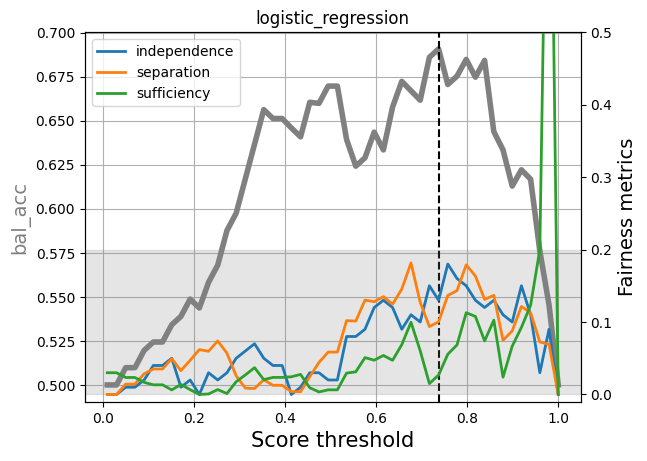

In [10]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

In [11]:
display(Markdown("**Test set results**"))
utils.print_metrics(metrics_best_thresh_test[model_name+fairness_method])

**Test set results**

Threshold corresponding to *best balanced accuracy*: 0.7373
AUC: 0.7593
Balanced accuracy: 0.7457
Accuracy: 0.7000
Independence ( |ΔP(Y_pred = 1)| ): 0.1883
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0599
Sufficiency ( |ΔPPV| ) : 0.1154


In [12]:
%%time 

# Nombramos al modelo
model_name = 'xgb_classifier'
fairness_method = ''

# Parámetros del modelo
fit_params = {'eval_metric': 'error', 'eta':0.1, 'max_depth':6, 'subsample':0.8}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = XGBClassifier(**fit_params)

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel())

CPU times: total: 1.75 s
Wall time: 559 ms


**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.7980
AUC: 0.7384
Balanced accuracy: 0.7056
Accuracy: 0.6867
Independence ( |ΔP(Y_pred = 1)| ): 0.0100
Separation ( |ΔFPR + ΔFNR|/2 ): 0.2365
Sufficiency ( |ΔPPV| ) : 0.1820
CPU times: total: 1.33 s
Wall time: 163 ms


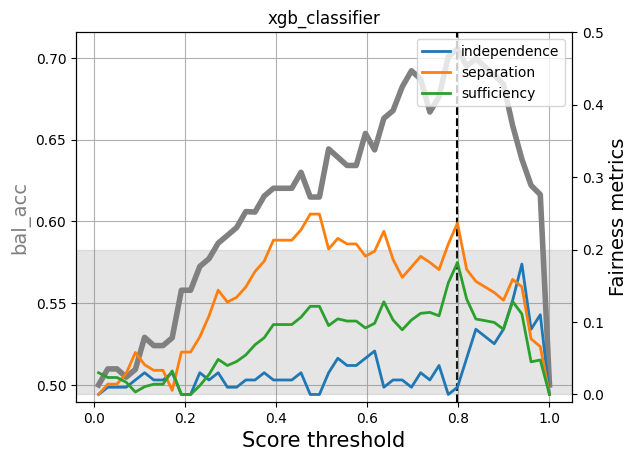

In [13]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

In [14]:
display(Markdown("**Test set results**"))
utils.print_metrics(metrics_best_thresh_test[model_name+fairness_method])

**Test set results**

Threshold corresponding to *best balanced accuracy*: 0.7980
AUC: 0.7737
Balanced accuracy: 0.6999
Accuracy: 0.6667
Independence ( |ΔP(Y_pred = 1)| ): 0.1574
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0151
Sufficiency ( |ΔPPV| ) : 0.0346


## Técnicas de Preprocesamiento

### Reweighting

In [15]:
%%time 
# Nombramos al modelo
fairness_method = '_reweighting'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos el pre-procesado al conjunto train
# Inicializamos la clase de pre-procesado 
PreProcessor = Reweighing(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)
# Pre-procesamos (modifica los datos)
PreProcessor.fit(data_train_copy)
data_train_copy = PreProcessor.transform(data_train_copy)
data_val_copy = PreProcessor.transform(data_val_copy)
data_test_copy = PreProcessor.transform(data_test_copy)

CPU times: total: 15.6 ms
Wall time: 8.05 ms


De aquí en adelante, se aplica el modelo de preferencia de manera estándar

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.7778
AUC: 0.7443
Balanced accuracy: 0.6943
Accuracy: 0.6648
Independence ( |ΔP(Y_pred = 1)| ): 0.0516
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1058
Sufficiency ( |ΔPPV| ) : 0.0055
CPU times: total: 109 ms
Wall time: 115 ms


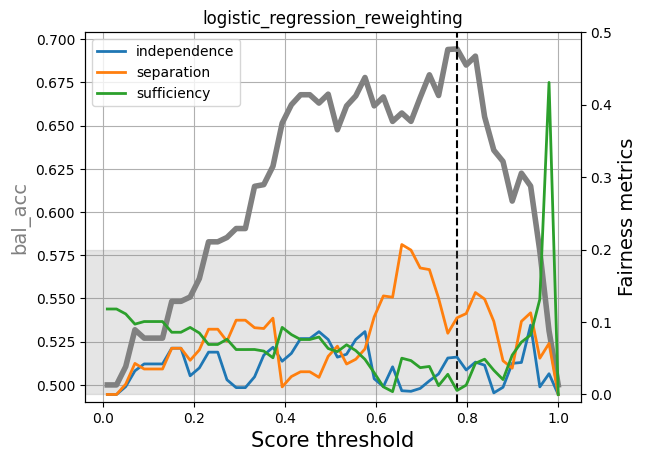

In [16]:
%%time 

# Regresión logística
model_name = 'logistic_regression'

# Parámetros del modelo
fit_params = {'logisticregression__sample_weight': data_train_copy.instance_weights}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = make_pipeline(
            #StandardScaler(),
            LogisticRegression(solver='liblinear', random_state=seed))

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel(), **fit_params)

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.7980
AUC: 0.7384
Balanced accuracy: 0.7116
Accuracy: 0.6893
Independence ( |ΔP(Y_pred = 1)| ): 0.0125
Separation ( |ΔFPR + ΔFNR|/2 ): 0.2365
Sufficiency ( |ΔPPV| ) : 0.1170
CPU times: total: 3.45 s
Wall time: 632 ms


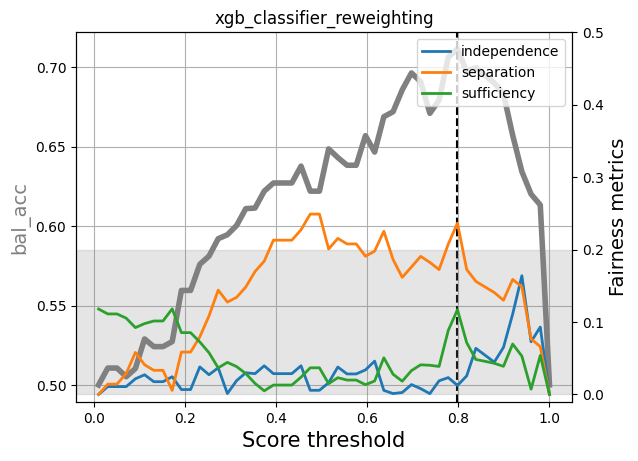

In [17]:
%%time 

# Nombramos al modelo
model_name = 'xgb_classifier'

# Parámetros del modelo
fit_params = {'eval_metric': 'error', 'eta':0.1, 'max_depth':6, 'subsample':0.8}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = XGBClassifier(**fit_params)

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel())

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

### Disparate Impact Remover

In [18]:
%%time 
# Nombramos al modelo
fairness_method = '_di_remover'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Parámetros del modelo
nivel_reparacion = 0.5 # un valor 0 inidica ausencia de reparación (datos se mantienen igual) 
                       # un valor 1 indica reparación completa (se puede perder nivel predictivo).
                       # Se puede establecer cualquier valor entre 0 y 1.

# Hacemos el pre-procesado al conjunto train
# Inicializamos la clase de pre-procesado 
PreProcessor = DisparateImpactRemover(
    repair_level=nivel_reparacion,
    sensitive_attribute=sensitive_attribute
)
# Pre-procesamos (modifica los datos)
PreProcessor.fit_transform(data_train_copy)
data_train_copy = PreProcessor.fit_transform(data_train_copy)
data_val_copy = PreProcessor.fit_transform(data_val_copy)
data_test_copy = PreProcessor.fit_transform(data_test_copy)

CPU times: total: 391 ms
Wall time: 391 ms


**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.7171
AUC: 0.7374
Balanced accuracy: 0.7011
Accuracy: 0.6933
Independence ( |ΔP(Y_pred = 1)| ): 0.1500
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0944
Sufficiency ( |ΔPPV| ) : 0.0123
CPU times: total: 125 ms
Wall time: 122 ms


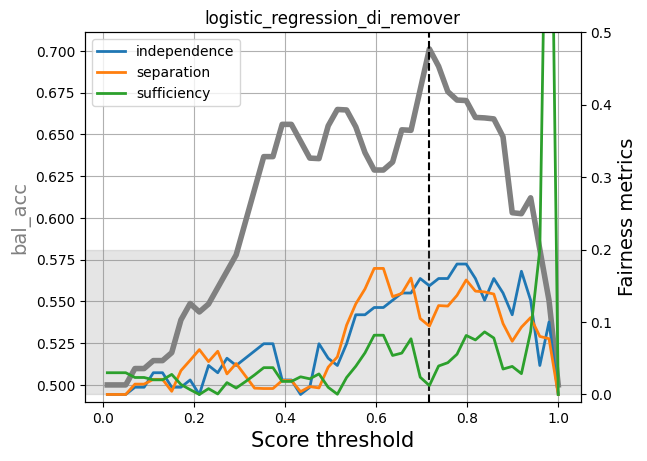

In [19]:
%%time 
# Regresión logística
model_name = 'logistic_regression'

# Parámetros del modelo
fit_params = {'logisticregression__sample_weight': data_train_copy.instance_weights}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = make_pipeline(
            #StandardScaler(),
            LogisticRegression(solver='liblinear', random_state=seed))

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel(), **fit_params)

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.9394
AUC: 0.7039
Balanced accuracy: 0.6729
Accuracy: 0.5933
Independence ( |ΔP(Y_pred = 1)| ): 0.1900
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1323
Sufficiency ( |ΔPPV| ) : 0.0300
CPU times: total: 1.66 s
Wall time: 269 ms


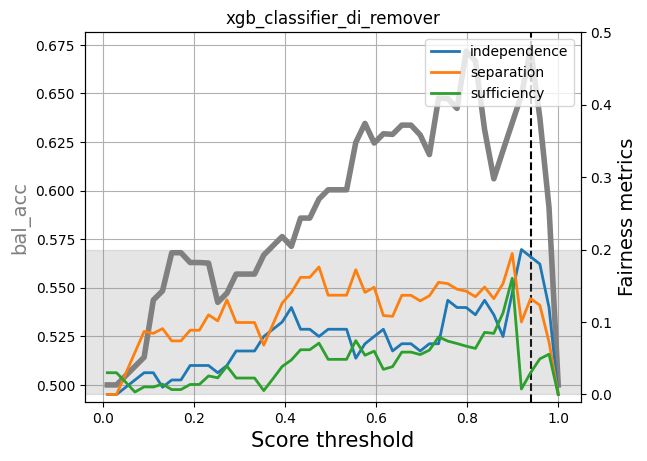

In [20]:
%%time 

# Nombramos al modelo
model_name = 'xgb_classifier'

# Parámetros del modelo
fit_params = {'eval_metric': 'error', 'eta':0.1, 'max_depth':6, 'subsample':0.8}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = XGBClassifier(**fit_params)

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel())

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])


# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

## Técnicas de Procesamiento Interno

### Adversarial Debiasing

In [21]:
%%time

# Nombramos al modelo
model_name = 'NN_adversarial_debiasing'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

sess = tf.Session()

models[model_name] = AdversarialDebiasing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    scope_name = 'debiased_classifier',
    debias=True,
    sess=sess,
    num_epochs=125)

models[model_name].fit(data_train_copy)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

epoch 0; iter: 0; batch classifier loss: 78.439835; batch adversarial loss: 0.709411
epoch 1; iter: 0; batch classifier loss: 69.954170; batch adversarial loss: 0.663188
epoch 2; iter: 0; batch classifier loss: 33.522217; batch adversarial loss: 0.633100
epoch 3; iter: 0; batch classifier loss: 42.246437; batch adversarial loss: 0.612571
epoch 4; iter: 0; batch classifier loss: 37.379868; batch adversarial loss: 0.640813
epoch 5; iter: 0; batch classifier loss: 54.969368; batch adversarial loss: 0.682673
epoch 6; iter: 0; batch classifier loss: 51.549896; batch adversarial loss: 0.606602
epoch 7; iter: 0; batch classifier loss: 41.848564; batch adversarial loss: 0.626343
epoch 8; iter: 0; batch classifier loss: 43.669487; batch adversarial loss: 0.620395
epoch 9; iter: 0; batch classifier loss: 45.049297; batch adversarial loss: 0.632568
epoch 10; iter: 0; batch classifie

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.6565
AUC: 0.5672
Balanced accuracy: 0.6070
Accuracy: 0.7133
Independence ( |ΔP(Y_pred = 1)| ): 0.0400
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1425
Sufficiency ( |ΔPPV| ) : 0.1039
CPU times: total: 109 ms
Wall time: 120 ms


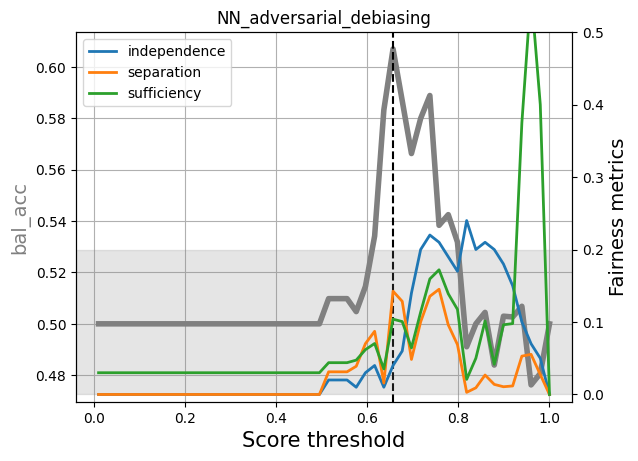

In [22]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

#### Eliminación de prejuicios adversarios: Red neuronal sin eliminación de prejuicios

In [23]:
%%time

sess.close()
tf.reset_default_graph()
sess = tf.Session()

# Nombramos al modelo
model_name = 'Basic_NN_no_adversarial_debiasing'

# Hacemos una copia de los datasets"
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

models[model_name] = AdversarialDebiasing(privileged_groups = privileged_groups,
                                          unprivileged_groups = unprivileged_groups,
                                          scope_name = 'biased_classifier',
                                          debias=False,
                                          sess=sess,
                                          num_epochs=125)
models[model_name].fit(data_train_copy)

epoch 0; iter: 0; batch classifier loss: 98.336716
epoch 1; iter: 0; batch classifier loss: 70.526848
epoch 2; iter: 0; batch classifier loss: 83.360878
epoch 3; iter: 0; batch classifier loss: 27.710012
epoch 4; iter: 0; batch classifier loss: 55.084930
epoch 5; iter: 0; batch classifier loss: 65.442764
epoch 6; iter: 0; batch classifier loss: 33.271206
epoch 7; iter: 0; batch classifier loss: 58.134754
epoch 8; iter: 0; batch classifier loss: 52.832699
epoch 9; iter: 0; batch classifier loss: 42.371712
epoch 10; iter: 0; batch classifier loss: 43.878742
epoch 11; iter: 0; batch classifier loss: 55.530548
epoch 12; iter: 0; batch classifier loss: 53.815964
epoch 13; iter: 0; batch classifier loss: 48.692863
epoch 14; iter: 0; batch classifier loss: 57.637119
epoch 15; iter: 0; batch classifier loss: 27.787394
epoch 16; iter: 0; batch classifier loss: 35.346283
epoch 17; iter: 0; batch classifier loss: 33.287781
epoch 18; iter: 0; batch classifier loss: 44.241005
epoch 19; iter: 0; bat

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.4949
AUC: 0.7469
Balanced accuracy: 0.7249
Accuracy: 0.6933
Independence ( |ΔP(Y_pred = 1)| ): 0.0800
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0818
Sufficiency ( |ΔPPV| ) : 0.0229
CPU times: total: 93.8 ms
Wall time: 120 ms


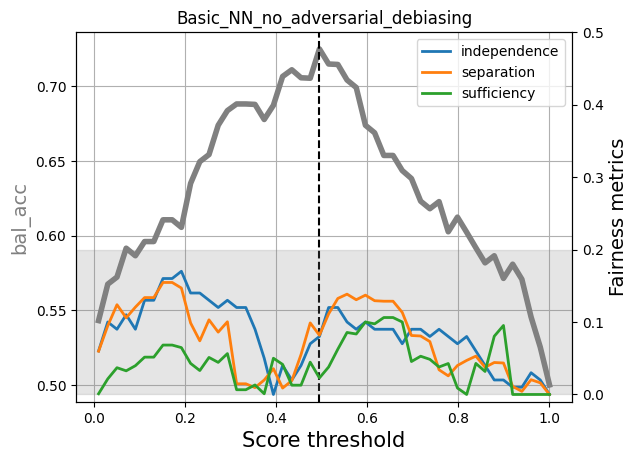

In [24]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

### Prejudice Remover

In [25]:
%%time 
# Nombramos al modelo
model_name = 'prejudice_remover'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Parámetros del modelo
η = 50.0 # hyper-parameter de regularización

# Inicializamos el modelo y lo asignamos al diccionario
models[model_name] = PrejudiceRemover(sensitive_attr=sensitive_attribute, eta=η)

# Entrenamos el modelo
models[model_name] = models[model_name].fit(data_train_copy)

CPU times: total: 31.2 ms
Wall time: 2.71 s


**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.7171
AUC: 0.7467
Balanced accuracy: 0.7014
Accuracy: 0.7000
Independence ( |ΔP(Y_pred = 1)| ): 0.0900
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0962
Sufficiency ( |ΔPPV| ) : 0.0305
CPU times: total: 172 ms
Wall time: 3.98 s


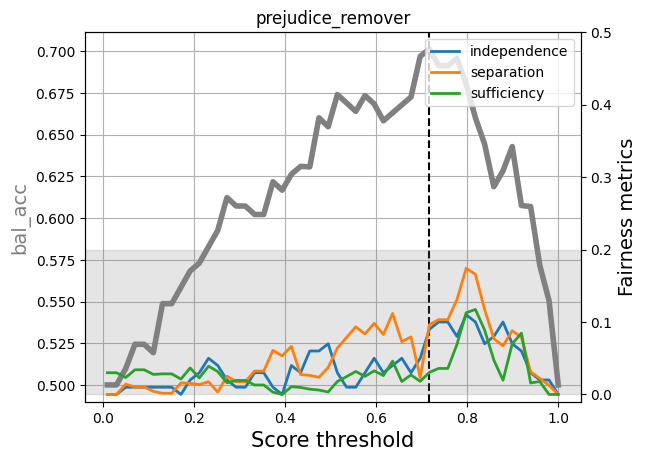

In [26]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep(
    dataset=data_val_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics(
    dataset=data_test_copy, 
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

## Técnicas de Postprocesamiento

### Equalized Odds

#### Usando Labels

In [27]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'logistic_regression'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

CPU times: total: 0 ns
Wall time: 10.5 ms


Threshold corresponding to *best balanced accuracy*: 0.8182
AUC: 0.7435
Balanced accuracy: 0.6955
Accuracy: 0.6733
Independence ( |ΔP(Y_pred = 1)| ): 0.0700
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1083
Sufficiency ( |ΔPPV| ) : 0.0946


CPU times: total: 219 ms
Wall time: 220 ms


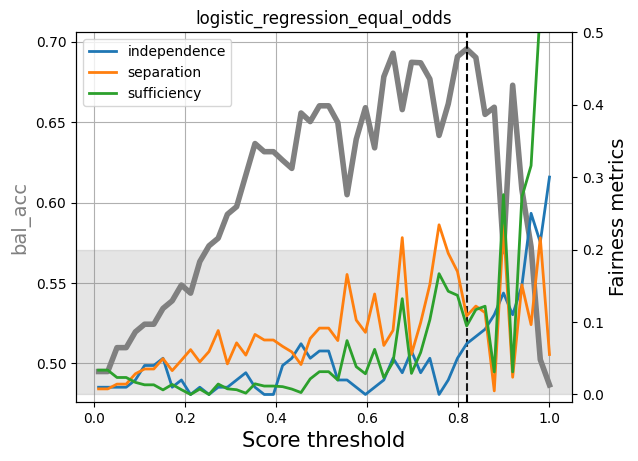

In [28]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

In [29]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'xgb_classifier'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    # cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

CPU times: total: 78.1 ms
Wall time: 18 ms


Threshold corresponding to *best balanced accuracy*: 0.7980
AUC: 0.7384
Balanced accuracy: 0.7056
Accuracy: 0.6867
Independence ( |ΔP(Y_pred = 1)| ): 0.0100
Separation ( |ΔFPR + ΔFNR|/2 ): 0.2365
Sufficiency ( |ΔPPV| ) : 0.1820


CPU times: total: 250 ms
Wall time: 208 ms


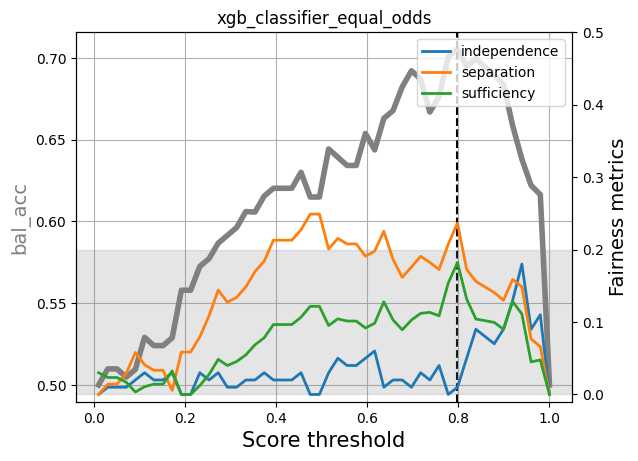

In [30]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

#### Usando Scores

In [31]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'logistic_regression'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: total: 46.9 ms
Wall time: 22.1 ms


In [32]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for logistic regression**

Results for logistic_regression_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.7373
AUC: 0.7435
Balanced accuracy: 0.6762
Accuracy: 0.6667
Independence ( |ΔP(Y_pred = 1)| ): 0.1600
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0794
Sufficiency ( |ΔPPV| ) : 0.0008


Results for logistic_regression_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.7373
AUC: 0.7435
Balanced accuracy: 0.5989
Accuracy: 0.6400
Independence ( |ΔP(Y_pred = 1)| ): 0.3600
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0305
Sufficiency ( |ΔPPV| ) : 0.1044


Results for logistic_regression_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.6565
AUC: 0.7435
Balanced accuracy: 0.6961
Accuracy: 0.6867
Independence ( |ΔP(Y_pred = 1)| ): 0.2900
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0628
Sufficiency ( |ΔPPV| ) : 0.0728




In [33]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'xgb_classifier'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: total: 62.5 ms
Wall time: 24.2 ms


In [34]:
display(Markdown("**Validation set results for xgb classifier**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for xgb classifier**

Results for xgb_classifier_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.7980
AUC: 0.7384
Balanced accuracy: 0.7005
Accuracy: 0.6800
Independence ( |ΔP(Y_pred = 1)| ): 0.0000
Separation ( |ΔFPR + ΔFNR|/2 ): 0.2288
Sufficiency ( |ΔPPV| ) : 0.1800


Results for xgb_classifier_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.6969
AUC: 0.7384
Balanced accuracy: 0.6922
Accuracy: 0.7067
Independence ( |ΔP(Y_pred = 1)| ): 0.0100
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1759
Sufficiency ( |ΔPPV| ) : 0.1027


Results for xgb_classifier_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.7980
AUC: 0.7384
Balanced accuracy: 0.7053
Accuracy: 0.6800
Independence ( |ΔP(Y_pred = 1)| ): 0.0700
Separation ( |ΔFPR + ΔFNR|/2 ): 0.2346
Sufficiency ( |ΔPPV| ) : 0.1747




### Reject Option

In [35]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = 'logistic_regression'

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: total: 10 s
Wall time: 10.7 s


In [36]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for logistic regression**

logistic_regression_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.7524
AUC: 0.7435
Balanced accuracy: 0.6904
Accuracy: 0.6667
Independence ( |ΔP(Y_pred = 1)| ): 0.0700
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1447
Sufficiency ( |ΔPPV| ) : 0.0900


logistic_regression_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.7722
AUC: 0.7435
Balanced accuracy: 0.6949
Accuracy: 0.6600
Independence ( |ΔP(Y_pred = 1)| ): 0.1100
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1495
Sufficiency ( |ΔPPV| ) : 0.0881


logistic_regression_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.6831
AUC: 0.7435
Balanced accuracy: 0.6569
Accuracy: 0.6600
Independence ( |ΔP(Y_pred = 1)| ): 0.0600
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1437
Sufficiency ( |ΔPPV| ) : 0.0796




In [37]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = 'xgb_classifier'

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: total: 9.56 s
Wall time: 10.3 s


In [38]:
display(Markdown("**Validation set results for xgb classifier**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for xgb classifier**

xgb_classifier_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.6633
AUC: 0.7384
Balanced accuracy: 0.6765
Accuracy: 0.6733
Independence ( |ΔP(Y_pred = 1)| ): 0.2300
Separation ( |ΔFPR + ΔFNR|/2 ): 0.2425
Sufficiency ( |ΔPPV| ) : 0.2079


xgb_classifier_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.6237
AUC: 0.7384
Balanced accuracy: 0.6631
Accuracy: 0.6933
Independence ( |ΔP(Y_pred = 1)| ): 0.0100
Separation ( |ΔFPR + ΔFNR|/2 ): 0.2252
Sufficiency ( |ΔPPV| ) : 0.1279


xgb_classifier_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.6237
AUC: 0.7384
Balanced accuracy: 0.6631
Accuracy: 0.6933
Independence ( |ΔP(Y_pred = 1)| ): 0.0100
Separation ( |ΔFPR + ΔFNR|/2 ): 0.2252
Sufficiency ( |ΔPPV| ) : 0.1279




## Comparación de modelos

Podemos usar los disccionarios que resumen la calidad de los modelos fair para compararlos todos

### Resultados en el conjunto de validación

In [39]:
algorithm_performance_summary = pd.DataFrame(metrics_best_thresh_validate).T
algorithm_performance_summary

,best_threshold,bal_acc,acc,independence,separation,sufficiency,auc
logistic_regression,0.737347,0.690731,0.673333,0.130000,0.100275,0.026840,0.743514
xgb_classifier,0.797959,0.705585,0.686667,0.010000,0.236462,0.181961,0.738364
logistic_regression_reweighting,0.777755,0.694345,0.664850,0.051584,0.105769,0.005504,0.744306
xgb_classifier_reweighting,0.797959,0.711628,0.689324,0.012457,0.236462,0.116976,0.738364
logistic_regression_di_remover,0.717143,0.701129,0.693333,0.150000,0.094360,0.012327,0.737374
xgb_classifier_di_remover,0.939388,0.672906,0.593333,0.190000,0.132284,0.030030,0.703902
NN_adversarial_debiasing,0.656531,0.606952,0.713333,0.040000,0.142506,0.103896,0.567241
Basic_NN_no_adversarial_debiasing,0.494898,0.724896,0.693333,0.080000,0.081791,0.022857,0.746881
prejudice_remover,0.717143,0.701426,0.700000,0.090000,0.096198,0.030508,0.746683
logistic_regression_equal_odds,0.818163,0.695484,0.673333,0.070000,0.108347,0.094563,0.743514


### Resultados en el conjunto de prueba (test set)

In [40]:
algorithm_performance_summary = pd.DataFrame(metrics_best_thresh_test).T
algorithm_performance_summary

,best_threshold,bal_acc,acc,independence,separation,sufficiency,auc
logistic_regression,0.737347,0.745706,0.700000,0.188321,0.059866,0.115385,0.759345
xgb_classifier,0.797959,0.699939,0.666667,0.157406,0.015134,0.034591,0.773692
logistic_regression_reweighting,0.777755,0.701118,0.649826,0.033891,0.100718,0.106646,0.741968
xgb_classifier_reweighting,0.797959,0.695294,0.661982,0.122421,0.015134,0.016484,0.773692
logistic_regression_di_remover,0.717143,0.740150,0.706667,0.177208,0.055460,0.071717,0.755102
xgb_classifier_di_remover,0.939388,0.647606,0.546667,0.173975,0.028975,0.093750,0.787028
NN_adversarial_debiasing,0.656531,0.512023,0.640000,0.114973,0.052921,0.091137,0.502728
Basic_NN_no_adversarial_debiasing,0.494898,0.695595,0.646667,0.057789,0.142146,0.102924,0.755708
prejudice_remover,0.717143,0.745100,0.713333,0.217418,0.024330,0.063983,0.761568
logistic_regression_equal_odds,0.818163,0.670236,0.626667,0.023237,0.009579,0.110994,0.759345
